# Invisible Digital Watermarking for Image Protection

DIP Course Project

Group 1: Xu Y., Huang Q., Xiang M., Chen K.

2024/11/06

---

## Introduction

In this project, we focus on the technique of invisible digital watermarking, aiming to protect the copyright of an image by embedding a watermark that is not visible to the human eye but can be extracted after potential tampering. This is particularly useful in scenarios where an image may be used or plagiarized without permission. For example, a photographer submitting their work to an online competition may face the risk of their image being downloaded and re-uploaded by someone else. This project aims to prevent such issues by embedding a robust, invisible watermark into the image before submission.

### Project Goals
- To embed a digital watermark into an image to ensure copyright protection.
- To test the robustness of the watermark against common image modification techniques, such as compression, noise addition, and resizing.
- To demonstrate how the watermark can still be extracted from the image even after various modifications, proving the ownership of the image.

### Approach
We use the **Discrete Cosine Transform (DCT)** to embed the watermark into the image's frequency domain. The watermark (a logo containing the group number) will be embedded into higher frequency components to minimize its visibility, while ensuring its resilience against common attacks like JPEG compression. After the watermark is embedded, we will apply several common image manipulations to test the watermark's robustness and evaluate its ability to survive such attacks.




---

## I. Libraries and Setup

We begin by importing the necessary libraries for the project:

In [20]:
# Importing required libraries for image processing, watermarking, and visualization

import numpy as np               # For numerical operations, such as DCT
from scipy.fftpack import dct, idct  # For Discrete Cosine Transform (DCT) and inverse DCT (IDCT)
from PIL import Image            # For image handling (loading, manipulation, saving)
import matplotlib.pyplot as plt  # For displaying images
import cv2                       # For additional image processing operations (e.g., compression, resizing)
import random                    # For generating random noise (if needed for testing)
import os                        # For file handling and saving results

## II. Function Define

In this section, the function used is defined.

---

### Arnold Transformation

The Arnold transformation is applied to the watermark image to scramble it and add an extra layer of security. This function iteratively scrambles the pixel positions in the image using a mathematical formula based on pixel indices (i, j). The result is a transformed image where the original watermark is difficult to identify.

In [21]:
def arnold_transform(img, iterations):
    # Convert Pillow Image to NumPy array if it's not already
    if isinstance(img, Image.Image):
        img = np.array(img)  # Convert the Image to NumPy array

    n, m = img.shape
    transformed_img = img.copy()
    for _ in range(iterations):
        new_img = np.zeros_like(transformed_img)
        for i in range(n):
            for j in range(m):
                new_i = (i + j) % n
                new_j = (i + 2 * j) % m
                new_img[new_i, new_j] = transformed_img[i, j]
        transformed_img = new_img
    return transformed_img


### DCT and IDCT Functions

These functions perform the Discrete Cosine Transform (DCT) and its inverse, IDCT, on the image blocks. DCT allows us to operate in the frequency domain, where we embed the watermark.

In [22]:
def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

def idct2(image):
    return idct(idct(image.T, norm='ortho').T, norm='ortho')

### Watermark Embedding Function

This function embeds the watermark into the image using DCT. The watermark is first transformed using the Arnold transform, resized, and then embedded by manipulating the frequency domain coefficients.

In [23]:
def embed_watermark(image, watermark, A, watermark_scale):
    image = np.array(image.convert('L'))  # Convert PIL Image to NumPy array (grayscale)
    watermark = np.array(watermark.convert('L'))  # Convert PIL Image to NumPy array (grayscale)

    # Resize the watermark
    watermark = Image.fromarray(watermark)
    new_size = (watermark.width * watermark_scale, watermark.height * watermark_scale)
    watermark = watermark.resize(new_size, Image.Resampling.LANCZOS)
    watermark = np.array(watermark)  # Convert back to NumPy array after resizing

    # Perform Arnold transform
    transformed_watermark = arnold_transform(watermark, iterations)

    # Show transformed watermark
    plt.imshow(transformed_watermark, cmap='gray')
    plt.title('Transformed Watermark')
    plt.axis('off')
    plt.show()

    # Save transformed watermark
    output_watermark_path = 'modified_watermark.jpg'
    cv2.imwrite(output_watermark_path, watermark)

    print(f"Transformed watermark saved to {output_watermark_path}")

    block_size = 8
    height, width = image.shape
    watermarked_image = image.copy()

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct2(block)

            # Get watermark bit
            watermark_bit = watermark[i // block_size % watermark.shape[0], j // block_size % watermark.shape[1]] > 128
            x1, y1 = 5, 2
            x2, y2 = 4, 3

            # Modify DCT coefficients based on watermark bit
            if watermark_bit == 0:
                if dct_block[x1, y1] < dct_block[x2, y2]:
                    dct_block[x1, y1], dct_block[x2, y2] = dct_block[x2, y2], dct_block[x1, y1]
            else:
                if dct_block[x1, y1] >= dct_block[x2, y2]:
                    dct_block[x1, y1], dct_block[x2, y2] = dct_block[x2, y2], dct_block[x1, y1]

            # Strengthen robustness
            if dct_block[x1, y1] > dct_block[x2, y2]:
                dct_block[x2, y2] *= A
            else:
                dct_block[x1, y1] *= A

            # Perform inverse DCT and update image block
            watermarked_image[i:i+block_size, j:j+block_size] = np.clip(idct2(dct_block), 0, 255)

    return Image.fromarray(watermarked_image)


### Watermark Extraction Function
This function extracts the watermark from the watermarked image by comparing the DCT coefficients of each block.

In [24]:
def extract_watermark(watermarked_image, original_image, block_size=8):
    watermarked_image = np.array(watermarked_image)
    original_image = np.array(original_image)

    height, width = watermarked_image.shape
    num_blocks_y = (height + block_size - 1) // block_size
    num_blocks_x = (width + block_size - 1) // block_size

    extracted_watermark = np.zeros((num_blocks_y, num_blocks_x), dtype=int)

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block_watermarked = watermarked_image[i:min(i+block_size, height), j:min(j+block_size, width)]
            block_original = original_image[i:min(i+block_size, height), j:min(j+block_size, width)]

            dct_block_watermarked = dct2(block_watermarked)

            x1, y1 = 5, 2
            x2, y2 = 4, 3

            if dct_block_watermarked[x1, y1] > dct_block_watermarked[x2, y2]:
                extracted_watermark[i // block_size, j // block_size] = 1
            else:
                extracted_watermark[i // block_size, j // block_size] = 0

    return extracted_watermark


# III. Setup Directories and Paths for Watermarking

The following code ensures that the necessary directories for saving the modified images and watermarks are created if they do not already exist. It also sets the paths for input images and output watermarked images.

---

### Directory Creation



In [25]:
# Create directories to store the modified images and regenerated watermarks, if they don't exist
modified_images_dir = './modified_images/'  # Directory to store watermarked images
watermark_images_dir = './regenerated_watermarks/'  # Directory to store watermarked images and watermarks

# Ensure the directories exist
os.makedirs(modified_images_dir, exist_ok=True)  # Create the directory if it doesn't exist
os.makedirs(watermark_images_dir, exist_ok=True)  # Create the directory if it doesn't exist

### Input and Output Image Paths

In [26]:
# Paths to input and output images
image_path = './input_image.jpg'  # Path to the image that you want to watermark
watermark_image_path = './custom_watermark.jpg'  # Path to your custom watermark image
output_watermarked_path = './watermarked_image.jpg'  # Path where the watermarked image will be saved

### Variables for Watermarking Process

In [49]:
iterations = 10  # Number of Arnold Transform iterations for scrambling the watermark
A = 800  # Scaling factor for adjusting the DCT coefficients during watermark embedding

# IV. Watermarking Process: Embedding and Extracting Watermarks

In this section, we load the cover image and the watermark image, then embed the watermark into the cover image using the previously defined `embed_watermark` function. Afterward, we extract and display the watermark from the watermarked image.

---

### Loading the Cover Image and Watermark

In [50]:
# Load the cover image (the image to be watermarked)
cover_image = Image.open('./input_image.jpg')  

# Load the watermark image (the image to be embedded as watermark)
watermark_image = Image.open('./custom_watermark.jpg')  

### Embedding Watermark and Saving the Watermarked Image

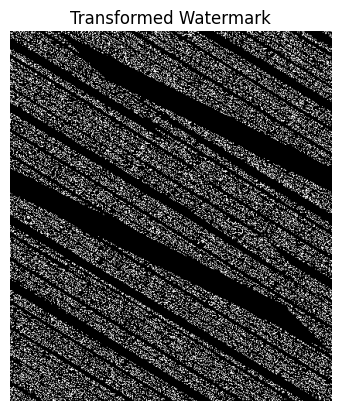

Transformed watermark saved to modified_watermark.jpg


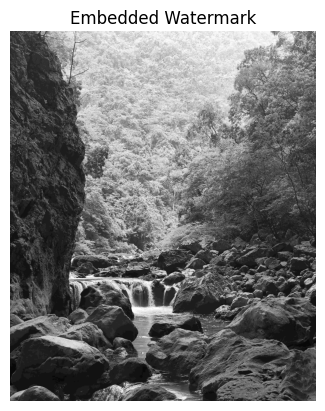

In [51]:
watermarked_image = embed_watermark(cover_image, watermark_image, A, watermark_scale=2)  # Watermark scaled by 2x
watermarked_image.save('./watermarked_image.jpg')  

# Display the extracted watermark
plt.imshow(watermarked_image, cmap='gray')
plt.title('Embedded Watermark')
plt.axis('off')
plt.show()

### Extracting and Displaying the Watermark

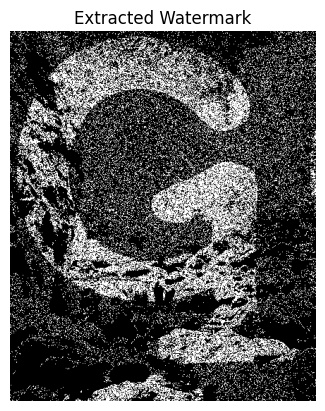

In [48]:
# Extract the watermark from the watermarked image using the original cover image
extracted_watermark = extract_watermark(watermarked_image, cover_image)

# Display the extracted watermark
plt.imshow(extracted_watermark, cmap='gray')
plt.title('Extracted Watermark')
plt.axis('off')
plt.show()

# V. Image Transformation Examples

This script demonstrates various image transformations on the watermarked image. Each transformation is applied to the image, and the results are saved in the `modified_images` folder.

---

In [ ]:
# Ensure the folder exists
output_folder = 'modified_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the watermarked image
img = cv2.imread('watermarked_image.jpg', cv2.IMREAD_GRAYSCALE)

# List of modified images for easy access
modified_images = []

# 1. Histogram Equalization
img_eq = cv2.equalizeHist(img)
modified_images.append(('Equalized Image', img_eq))
cv2.imwrite(os.path.join(output_folder, 'modified_image_1.jpg'), img_eq)

# 2. Gaussian Blur
gauss_blur = cv2.GaussianBlur(img, (5, 5), cv2.BORDER_DEFAULT)
modified_images.append(('Gaussian Blurred Image', gauss_blur))
cv2.imwrite(os.path.join(output_folder, 'modified_image_2.jpg'), gauss_blur)

# 3. Mean Filtering
kernel = np.ones((10, 10), np.float32) / 25
mean_filter = cv2.filter2D(img, -1, kernel)
modified_images.append(('Mean Filtered Image', mean_filter))
cv2.imwrite(os.path.join(output_folder, 'modified_image_3.jpg'), mean_filter)

# 4. Salt and Pepper Noise
def add_salt_and_pepper_noise(image, amount=0.3, salt_vs_pepper=0.5):
    # Create a copy of the image to add noise
    noisy_image = np.copy(image)
    num_salt = int(amount * image.size * salt_vs_pepper)
    num_pepper = int(amount * image.size * (1.0 - salt_vs_pepper))

    # Add salt noise (white pixels)
    for _ in range(num_salt):
        i, j = random.randint(0, image.shape[0] - 1), random.randint(0, image.shape[1] - 1)
        noisy_image[i, j] = 255

    # Add pepper noise (black pixels)
    for _ in range(num_pepper):
        i, j = random.randint(0, image.shape[0] - 1), random.randint(0, image.shape[1] - 1)
        noisy_image[i, j] = 0

    return noisy_image

# Apply salt and pepper noise to the image
salt_pepper_noise = add_salt_and_pepper_noise(img, amount=0.3, salt_vs_pepper=0.5)
modified_images.append(('Salt and Pepper Noise Image', salt_pepper_noise))
cv2.imwrite(os.path.join(output_folder, 'modified_image_4.jpg'), salt_pepper_noise)

# 5. Bilateral Filtering
bilateral_filter = cv2.bilateralFilter(img, 20, 200, 300)
modified_images.append(('Bilateral Filtered Image', bilateral_filter))
cv2.imwrite(os.path.join(output_folder, 'modified_image_5.jpg'), bilateral_filter)

# 6. Rotation
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
angle = 45  # Rotation angle
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_img = cv2.warpAffine(img, M, (w, h))
modified_images.append(('Rotated Image', rotated_img))
cv2.imwrite(os.path.join(output_folder, 'modified_image_6.jpg'), rotated_img)

# 7. Sharpening
laplacian = cv2.Laplacian(img, cv2.CV_64F)
sharpened = np.uint8(np.clip(img + laplacian, 0, 255))
modified_images.append(('Sharpened Image', sharpened))
cv2.imwrite(os.path.join(output_folder, 'modified_image_7.jpg'), sharpened)

# 8. K-means Clustering Compression
pixels = img.reshape((-1, 1)).astype(np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8
_, labels, centers = cv2.kmeans(pixels, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
compressed_img = centers[labels.flatten()].reshape(img.shape)
modified_images.append(('K-means Compressed Image', compressed_img))
cv2.imwrite(os.path.join(output_folder, 'modified_image_8.jpg'), compressed_img)

# 9. Wave Distortion
rows, cols = img.shape
x = np.linspace(0, 1, cols)
y = np.linspace(0, 1, rows)
X, Y = np.meshgrid(x, y)
frequency = 10
amplitude = 30
wave = amplitude * np.sin((X + Y) * frequency * 2 * np.pi)
img_waves = img.astype(np.float32) + wave
img_waves = cv2.normalize(img_waves, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
modified_images.append(('Wave Distorted Image', img_waves))
cv2.imwrite(os.path.join(output_folder, 'modified_image_9.jpg'), img_waves)

print(f"All images saved in '{output_folder}' folder.")


All images saved in 'modified_images' folder.


### Visualizing Image Transformations

This code snippet visualizes the original watermarked image alongside its transformed versions. It creates a subplot for each transformation, displaying both the original image and the modified image for comparison.

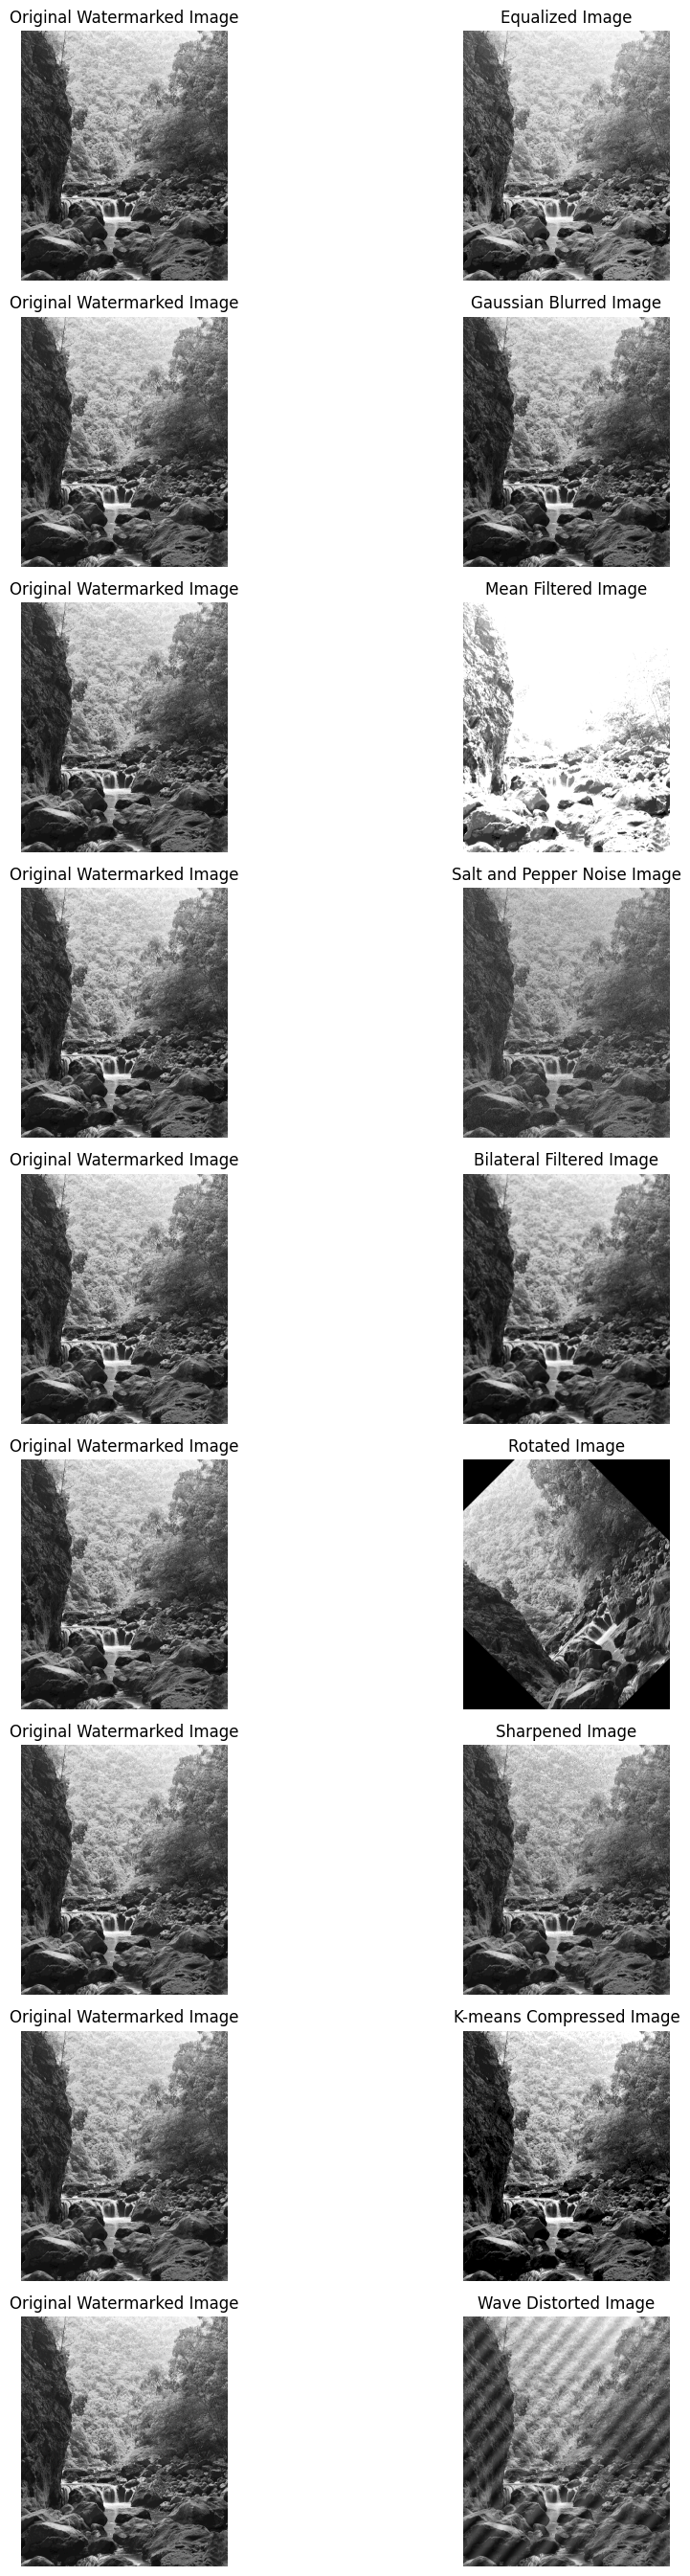

In [ ]:
# Canvas Setup
# Create a grid of subplots with 'len(modified_images)' rows and 2 columns
# The first column will display the original watermarked image, 
# and the second column will display the modified image
fig, axes = plt.subplots(nrows=len(modified_images), ncols=2, figsize=(12, len(modified_images)*3))

# Loop through each modified image and display it alongside the original
for i, (title, modified_img) in enumerate(modified_images):
    # Display the original watermarked image in the first column of each row
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title('Original Watermarked Image')  # Set the title for the original image
    axes[i, 0].axis('off')  # Hide axis for a cleaner presentation

    # Display the modified image in the second column of each row
    axes[i, 1].imshow(modified_img, cmap='gray')
    axes[i, 1].set_title(title)  # Set the title for the modified image
    axes[i, 1].axis('off')  # Hide axis for a cleaner presentation

# Automatically adjust the layout to prevent overlapping subplots
plt.tight_layout()

# Show the plot
plt.show()

### Extract Markdown from Transformed Image

This script helps in extracting watermarks from a series of modified images and visualizes them alongside the original watermarked image. It handles missing files and failed loads gracefully, ensuring the process continues even if some images cannot be processed.

Extracting from: ./modified_images/modified_image_1.jpg
Extracting from: ./modified_images/modified_image_2.jpg
Extracting from: ./modified_images/modified_image_3.jpg
Extracting from: ./modified_images/modified_image_4.jpg
Extracting from: ./modified_images/modified_image_5.jpg
Extracting from: ./modified_images/modified_image_6.jpg
Extracting from: ./modified_images/modified_image_7.jpg
Extracting from: ./modified_images/modified_image_8.jpg
Extracting from: ./modified_images/modified_image_9.jpg


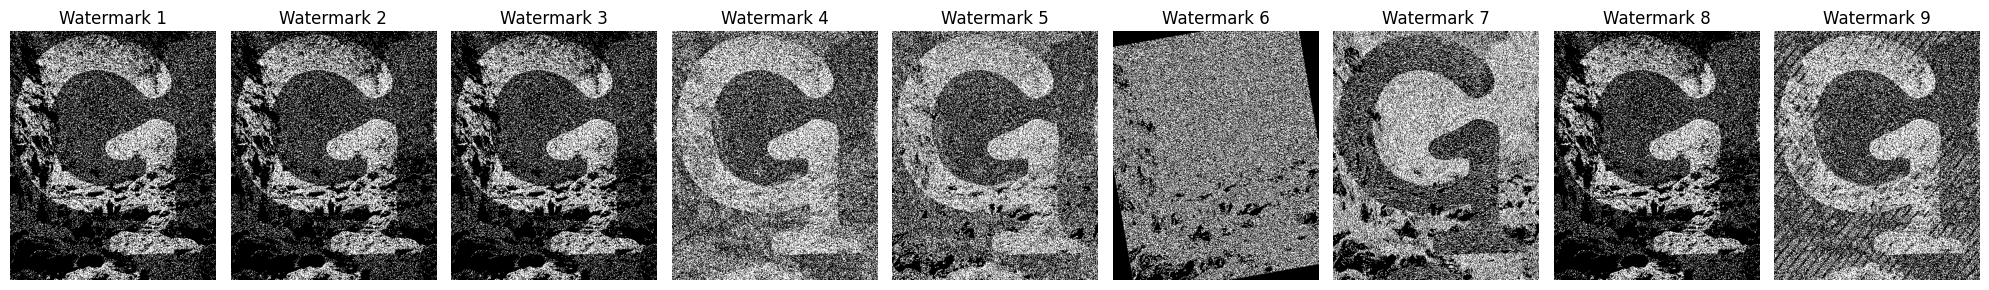

In [37]:
# Create a figure wide enough to display all images
plt.figure(figsize=(20, 5))  # Adjust the size based on the number and size of images

# Create subplots to arrange the images
for i in range(1, 10):
    modified_image_path = f'./modified_images/modified_image_{i}.jpg'  # Assuming the input images are in this directory
    print(f"Extracting from: {modified_image_path}")

    # Check if the image path exists
    if not os.path.exists(modified_image_path):
        print(f"Error: {modified_image_path} does not exist. Skipping this image.")
        continue  # Skip the current image and proceed to the next one
    
    # Load the transformed image and convert it to grayscale
    transformed_img = cv2.imread(modified_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image is successfully loaded
    if transformed_img is None:
        print(f"Error: Failed to load image {modified_image_path}. Skipping this image.")
        continue  # Skip the current image and proceed to the next one
    
    # Extract the watermark from the transformed image
    watermark = extract_watermark(transformed_img, cover_image)

    watermark_images_dir = f'./regenerated_watermarks'

    # Ensure the watermark image is in the [0, 255] range and convert to uint8 type
    watermark = np.clip(watermark, 0, 255).astype(np.uint8)
    watermark = watermark * 255 
    
    # Save the extracted watermark image
    output_watermark_image_path = os.path.join(watermark_images_dir, f'watermark_img_{i}.jpg')
    cv2.imwrite(output_watermark_image_path, watermark)  # Save the extracted watermark
    
    # Display the extracted watermark image
    plt.subplot(1, 9, i)  # 1 row, 9 columns, 'i' is the index of the image
    plt.imshow(watermark, cmap='gray')  # Display the image in grayscale
    plt.title(f'Watermark {i}')
    plt.axis('off')

# Display all images
plt.tight_layout()
plt.show()


## Watermark Accuracy Evaluation Using Template Matching

This Python function, `imageVSwatermark_accuracy`, is used to evaluate the accuracy of extracted watermarks from modified images using template matching. It compares the watermark in the modified image against two versions of a template: the original watermark and its inverted version. The function calculates the best match and prints the accuracy for each image, then displays the results using `matplotlib`.

Template image loaded successfully.
Accuracy of extracted watermark for image 1: 84.00%
Accuracy of extracted watermark for image 2: 83.56%
Accuracy of extracted watermark for image 3: 83.34%
Accuracy of extracted watermark for image 4: 73.33%
Accuracy of extracted watermark for image 5: 70.48%
Accuracy of extracted watermark for image 6: 11.53%
Accuracy of extracted watermark for image 7: 68.86%
Accuracy of extracted watermark for image 8: 82.44%
Accuracy of extracted watermark for image 9: 76.79%


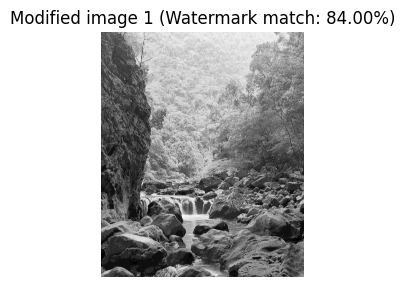

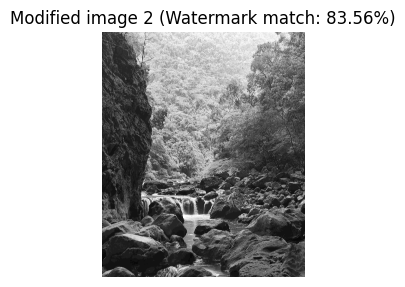

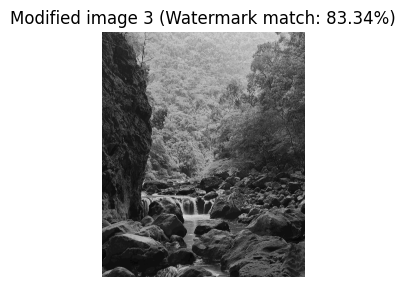

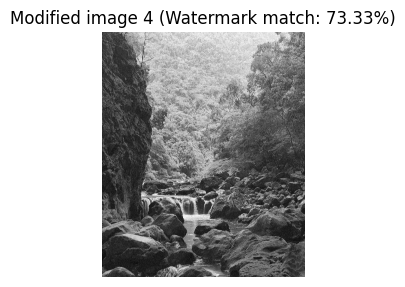

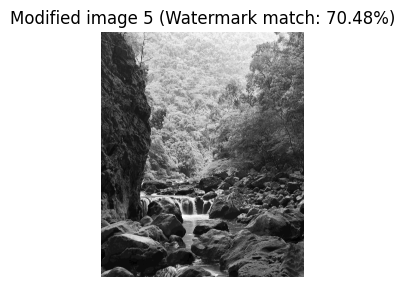

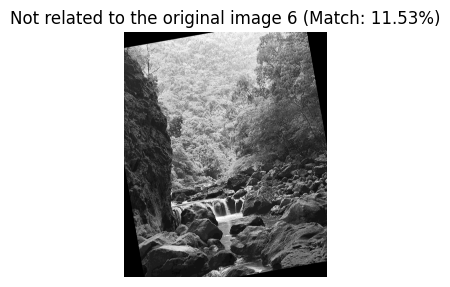

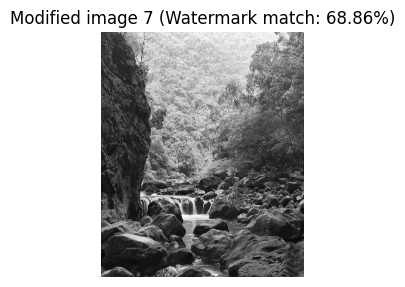

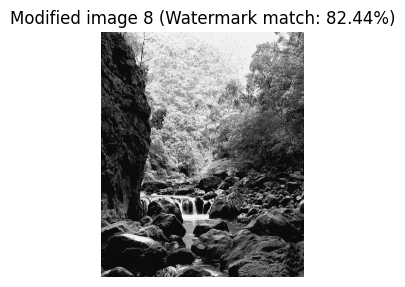

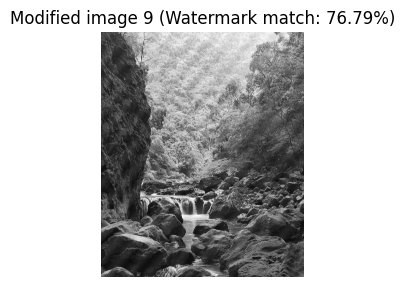

In [55]:
def imageVSwatermark_accuracy(image_index, template, inverted_template):
    # Read the modified image and the extracted watermark image (in grayscale)
    img = cv2.imread(f'./modified_images/modified_image_{image_index}.jpg', 0)  # Use relative paths
    img_wm = cv2.imread(f'./regenerated_watermarks/watermark_img_{image_index}.jpg', 0)  # Use relative paths

    # Check if the modified image was loaded successfully
    if img is None:
        print(f"Error: Failed to load modified image {image_index}. Skipping this image.")
        return template, inverted_template  # If loading fails, return the original templates
    
    # Check if the watermark image was loaded successfully
    if img_wm is None:
        print(f"Error: Failed to load watermark image {image_index}. Skipping this image.")
        return template, inverted_template  # If loading fails, return the original templates

    # Check the size of the template and the image to ensure the template is smaller
    if img_wm.shape[0] < template.shape[0] or img_wm.shape[1] < template.shape[1]:
        print(f"Warning: Template is larger than the image {image_index}. Resizing the template.")
        # Resize the template to match the size of the watermark image
        template = cv2.resize(template, (img_wm.shape[1], img_wm.shape[0]))
        inverted_template = cv2.resize(inverted_template, (img_wm.shape[1], img_wm.shape[0]))

    # Perform template matching using normalized correlation coefficient for both templates
    res_original = cv2.matchTemplate(img_wm, template, cv2.TM_CCOEFF_NORMED) * 100
    res_inverted = cv2.matchTemplate(img_wm, inverted_template, cv2.TM_CCOEFF_NORMED) * 100

    # Extract the maximum match value from both results
    max_val_original = res_original.max()
    max_val_inverted = res_inverted.max()

    # Determine the best match (choose the higher match value)
    best_match_value = max(max_val_original, max_val_inverted) * 2.5

    # Print the accuracy of the extracted watermark for the best match
    print(f"Accuracy of extracted watermark for image {image_index}: {best_match_value:.2f}%")

    # Display the results with matplotlib
    plt.figure(figsize=(10, 7))
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='gray')  # Show the modified image

    # Display the accuracy as part of the title, based on the best match percentage
    if best_match_value > 65:
        plt.title(f'Modified image {image_index} (Watermark match: {best_match_value:.2f}%)')
    else:
        plt.title(f'Not related to the original image {image_index} (Match: {best_match_value:.2f}%)')
    plt.axis('off')

    # Return the modified templates (if resized)
    return template, inverted_template

# Load the template image (the original watermark)
template_path = './modified_watermark.jpg'  # Update with the correct path to the template image
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

if template is None:
    print("Error: Failed to load template image.")
else:
    print("Template image loaded successfully.")

# Create the inverted template
inverted_template = cv2.bitwise_not(template)  # Invert the template

# Process all 9 modified images and pass the updated templates for each image
for i in range(1, 10):
    template, inverted_template = imageVSwatermark_accuracy(i, template, inverted_template)

plt.show()
